In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from lenstronomy.LightModel.Profiles.interpolation import Interpol
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
import scipy.optimize as opt

In [2]:
with fits.open('/Users/ethansilver/Downloads/goods_s_F115W_2018_08_29.fits') as hdul:
    header = hdul[0].header
    sim = hdul[0].data
with fits.open('/Users/ethansilver/Downloads/goods_s_F444W_2018_08_31.fits') as hdul:
    header2 = hdul[0].header
    sim2 = hdul[0].data
wcs = WCS(header)
wcs2 = WCS(header2)

with fits.open('/Users/ethansilver/Downloads/JADES_SF_mock_r1_v1.1.fits') as hdul:
    data = hdul[1].data

In [3]:
scale = 121/(53.21-53.165)/(-27.75+27.835)/60**2
scale

8.78721859113974

In [4]:
# plt.imshow(sim[5000:5050,8000:8050])
bkg = np.std(sim[5000:5050,8000:8050])
plt.figure()
# plt.imshow(sim2[5000:5050,7980:8030])
bkg2 = np.std(sim2[5000:5050,7980:8030])

<Figure size 432x288 with 0 Axes>

28830.864197529485

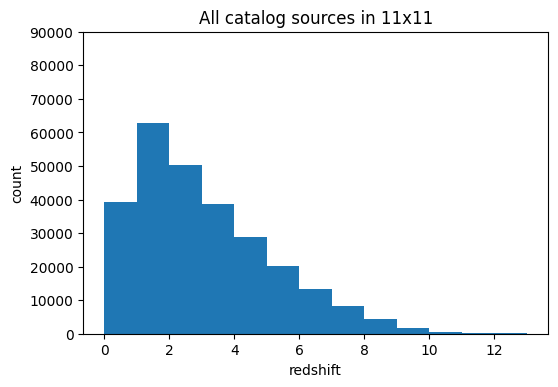

In [9]:
ticks = np.arange(0,100000,10000)
plt.figure(dpi=100)
plt.hist(cut['redshift'], bins=np.arange(0,14,1))
plt.yticks(ticks/scale, labels=ticks)
plt.xlabel("redshift")
plt.ylabel("count")
plt.title("All catalog sources in 11x11")
sum(cut['redshift']>6)*scale

In [20]:
sum((brights2>5) * (brights2<6))*scale, sum((cut['redshift']>5) * (cut['redshift']<6))*scale

(2671.3144517064807, 20113.943355118863)

NameError: name 'brights' is not defined

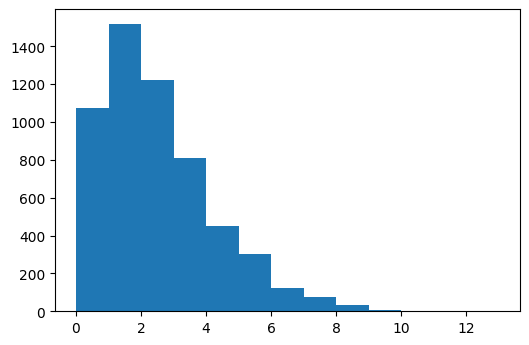

In [12]:
ticks = np.arange(0,20000,2000)
plt.figure(dpi=100)
plt.hist(brights2, label="F444W", bins=np.arange(0,14,1))
plt.hist(brights, label="F115W",bins=np.arange(0,14,1), alpha=0.7)

plt.yticks(ticks/scale, labels=ticks)
plt.xlabel("redshift")
plt.ylabel("count")
plt.title("Catalog sources in 11x11 $>5\sigma$")
plt.legend()


In [8]:
sum(cut['redshift']>6)
brights2 = []
for i in range(len(cut)):
    if i%1000==0:
        print(i)
    bright = cut[i]
    ra, dec = bright['RA'], bright['DEC']
    sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
    x, y = wcs2.world_to_pixel(sky)
    x, y = int(x), int(y)
    if sim2[y,x]>5*bkg2:
        brights2.append(bright['redshift'])
brights2 = np.array(brights2)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


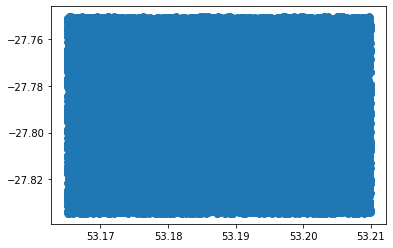

In [7]:
cut = data[data['RA']>53.165]
cut = cut[cut['RA']<53.21]
cut = cut[cut['DEC']<-27.75]
cut = cut[cut['DEC']>-27.835]
plt.scatter(cut['RA'], cut['DEC'])

In [19]:
def theta_E_S(c, m=1e13, z_lens=0.2, z_source=6.0, k=.1):
    factor=1.5*m/1e13
    lens_model = LensModel(['NFW', 'SERSIC_ELLIPSE_GAUSS_DEC'], z_lens=z_lens, z_source=z_source)
    lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source)
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=m, c=c)
#     print(Rs_angle, alpha_Rs)
    return opt.root(lambda x: lens_model.alpha(x,0, [{'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': 0., 'center_y': 0.}, 
                {'R_sersic': factor*np.sqrt(Rs_angle/10), 'n_sersic': 4, 'k_eff':k, 'center_x': 0., 'center_y': 0.}])[0]-x, 1).x[0]

masses = np.load("data/halo_masses2.npy")
zs = np.load("data/halo_zs2.npy")[masses>1e12]
concs = np.load("data/c2.npy")[masses>1e12]
masses = masses[masses>1e12]

In [20]:
k=3
idx = np.argpartition(masses, k)
print(idx)
print(masses[idx[:k]])

[ 93  32  76  51   8   3  25  33  68 100 103  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  10  26  27  28  29  30  31   9   7  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50   1  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67   6  69  70  71
  72  73  74  75   5  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92   4  94  95  96  97  98  99   2 101 102   0]
[1.00121914e+12 1.00855400e+12 1.01408895e+12]


In [42]:
m, c, z_lens =1e12, 8, 0.2

inds = np.argwhere((cut['NRC_F200W_fnu']>5e1) * (cut['redshift']>5))
Rs = np.array([int(cut['Re_maj'][i]/.03)*3 for i in range(len(cut))])
inds = np.argwhere((cut['redshift']>8.)*(Rs>3))
inds2 = inds.copy()
inds = []
for i in range(len(inds2)):
    bright = cut[inds2[i]][0]
    ra, dec = bright['RA'], bright['DEC']
    sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
    x, y = wcs.world_to_pixel(sky)
    x, y = int(x), int(y)
    if sim[y,x]>5*bkg:
        inds.append(inds2[i])
        



In [43]:
len(inds2), len(inds)

(248, 8)

0.985 6.056861425996905 1040508206214.6044
0.03644471055813014
0.03661006248815924
0.036843979524428576
0.036913070269324465
0.036928301251653466
0.037119319835632436
0.03755319271734617
0.03831762107046241


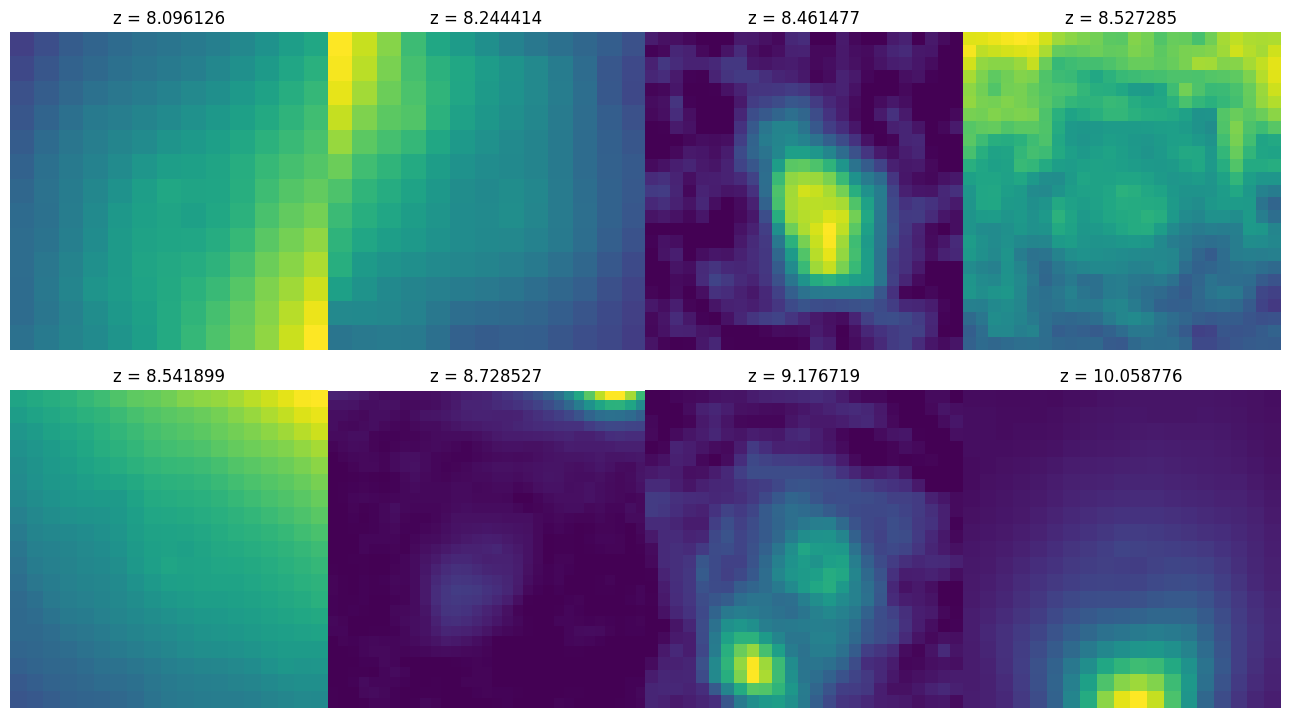

In [51]:
lens = idx[6]
z_lens = zs[lens]
c = concs[lens]+.5
m = masses[lens]
print(z_lens, c, m)


fig, axs=plt.subplots(2,4, dpi=100, figsize=(13,7.5))
for i in range(0,8):

    j = i-0
    bright = cut[inds[i]][0]
    R = int(bright['Re_maj']/.03)*3
    z_source = cut['redshift'][inds[i]][0]

    ra, dec = bright['RA'], bright['DEC']
    sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
    x, y = wcs.world_to_pixel(sky)
    x, y = int(x), int(y)
    
    gal = sim[y-R:y+R,x-R:x+R]
    while gal[R,R]==0:
        ij = i+10
        bright = cut[inds[ij]][0]
        R = int(bright['Re_maj']/.03)*3
        z_source = cut['redshift'][inds[ij]][0]

        ra, dec = bright['RA'], bright['DEC']
        sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
        x, y = wcs.world_to_pixel(sky)
        x, y = int(x), int(y)

        gal = sim[y-R:y+R,x-R:x+R]
        ij += 1
    
    pixels = 2*R+1
    pixel_size = .03
    background_rms = 0.02
    exp_time = 1380

    kwargs_data = {'background_rms': background_rms, 'exposure_time': exp_time,
                   'ra_at_xy_0': -pixels/2*pixel_size, 'dec_at_xy_0': -pixels/2*pixel_size,
                   'transform_pix2angle':np.array([[pixel_size, 0.  ], [0.  , pixel_size]]), 
                   'image_data': np.zeros((pixels, pixels))}

    kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

    data_class = ImageData(**kwargs_data)

    #PSF
    kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.03, 'pixel_size': pixel_size, 'truncation': 3}
#     kwargs_psf = {'psf_type':'NONE'}
    psf_class = PSF(**kwargs_psf)
    
    source_model_class = LightModel(['INTERPOL'])
    lens_light_model_class = LightModel(['SERSIC'])
    lens_model_class = LensModel(['NFW', 'SERSIC_ELLIPSE_GAUSS_DEC'], z_lens=z_lens, z_source=z_source)
    
    image_model = ImageModel(data_class=data_class, psf_class=psf_class, lens_model_class=lens_model_class, 
        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
        kwargs_numerics=kwargs_numerics)
    
    factor=1.5*m/1e13
    lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source)
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=m, c=c)
    k = c*.01*(m/1e13)**(1/3)*(np.log10(m)-9)/(13-9)

    
    kwargs_lens = [{'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': 0., 'center_y': 0.},
        {'R_sersic': factor*np.sqrt(Rs_angle/10), 'n_sersic': 4, 'k_eff':k, 'center_x': 0., 'center_y': 0.}]
#     kwargs_lens = [{'alpha_Rs': 0, 'Rs': Rs_angle, 'center_x': 0., 'center_y': 0.},
#         {'R_sersic': factor*np.sqrt(Rs_angle/10), 'n_sersic': 4, 'k_eff':0, 'center_x': 0., 'center_y': 0.}]
    kwargs_source = [{'image':gal, 'amp':1.2e3, 'scale':pixel_size, 'center_x':0.0, 'center_y':0.0}]
    kwargs_lens_light = [{'amp':.1, 'R_sersic': factor*np.sqrt(Rs_angle/10), 'n_sersic': 4, 'center_x': 0., 'center_y': 0.}]

    
    image = image_model.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None,
                               source_add=True, lens_light_add=True)
    
    axs[j//4,j%4].imshow(image, vmin=0)
    axs[j//4,j%4].axis('off')
    axs[j//4,j%4].set_title("z = "+str(z_source))
    
    print(theta_E_S(c,m,z_lens,z_source,k))

plt.tight_layout()
plt.subplots_adjust(hspace=0,wspace=0);

In [10]:
len(inds)

83